First, I need to try and figure out a way to download data from coinbase.

In [63]:
%matplotlib inline

In [65]:
from secret import api_key, api_secret

from coinbase.wallet.client import Client
from time import sleep

import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd

In [8]:
client = Client(api_key, api_secret)

In [11]:
client.get_spot_price(currency_pair = 'ETH-USD')

<APIObject @ 0x1107d1db0> {
  "amount": "448.57",
  "base": "ETH",
  "currency": "USD"
}

In [15]:
t = 1
act = 10**6
unit = 1
thres = 1
last = 0

while True:
    print(f'timestep: {t}, account: ${act}')
    print(client.get_spot_price(currency_pair = 'ETH-USD'))
    if 
    
    
    t += 1
    sleep(60)

1
{
  "amount": "448.39",
  "base": "ETH",
  "currency": "USD"
}
2
{
  "amount": "448.24",
  "base": "ETH",
  "currency": "USD"
}
3
{
  "amount": "447.41",
  "base": "ETH",
  "currency": "USD"
}


KeyboardInterrupt: 

In [16]:
res = client.get_spot_price(currency_pair = 'ETH-USD')

In [20]:
import json
data = json.loads(str(res))
data['amount']

'448.67'

Now we're going to implement a very simple trading strategy where we assume that there is no transaction costs.  basicallly, you trade against the movements of the currency.

In [27]:
t = 1
act = {'dol': 10**6, 'eth': 0, 'net': 0}
unit = 10
thres = 0.1
last = 0

while True:
    res = client.get_spot_price(currency_pair = 'ETH-USD')
    data = json.loads(str(res))
    
    curr_price = float(data['amount'])
    # buy
    if curr_price + thres < last and act['dol'] > unit * curr_price:
        act['dol'] -= curr_price * unit
        act['eth'] += unit
    
    # sell
    if curr_price - thres > last and act['eth'] > unit:
        act['dol'] += curr_price * unit
        act['eth'] -= unit
        
    # update total net worth
    act['net'] = act['dol'] + act['eth'] * curr_price
    print(f'timestep: {t}, spot price: {curr_price}, account: ${act}')
    last = curr_price
    t += 1
    sleep(60)

timestep: 1, spot price: 452.97, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
timestep: 2, spot price: 453.56, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
timestep: 3, spot price: 452.74, account: ${'dol': 995472.6, 'eth': 10, 'net': 1000000.0}
timestep: 4, spot price: 453.17, account: ${'dol': 995472.6, 'eth': 10, 'net': 1000004.2999999999}
timestep: 5, spot price: 453.44, account: ${'dol': 995472.6, 'eth': 10, 'net': 1000007.0}
timestep: 6, spot price: 453.27, account: ${'dol': 990939.9, 'eth': 20, 'net': 1000005.3}
timestep: 7, spot price: 453.41, account: ${'dol': 995474.0, 'eth': 10, 'net': 1000008.1}
timestep: 8, spot price: 453.48, account: ${'dol': 995474.0, 'eth': 10, 'net': 1000008.8}
timestep: 9, spot price: 453.03, account: ${'dol': 990943.7, 'eth': 20, 'net': 1000004.2999999999}
timestep: 10, spot price: 453.03, account: ${'dol': 990943.7, 'eth': 20, 'net': 1000004.2999999999}
timestep: 11, spot price: 453.41, account: ${'dol': 995477.7999999999, 'eth'

KeyboardInterrupt: 

Okay, after that very limited test, it APPEARS that the algorithm is making money.  However, the version used above is incredibly simple.

It doesn't take into account fees at all.  It also isn't fully executing a momentum strategy.  The unit of purchase should actually vary according to how much the price has changed between each time step.  Let's try to add both of those factors now.

First, let's add fee's.  To get results faster, I'll lower the threshold and make things more fun.

In [35]:
t = 1
start_val = 10**6
act = {'dol': start_val, 'eth': 0, 'net': 0}
unit = 100
thres = 0.1 # 10 cent XD
last = 0
fee_pc = 0.0025

while True:
    res = client.get_spot_price(currency_pair = 'ETH-USD')
    data = json.loads(str(res))
    
    curr_price = float(data['amount'])
    coin_num = unit
    order_amount = curr_price * coin_num
    order_tot = order_amount * (1+fee_pc)
    # buy
    if curr_price + thres < last and act['dol'] > order_tot:
        act['dol'] -= order_tot
        act['eth'] += coin_num
    
    # sell
    if curr_price - thres > last and act['eth'] > coin_num:
        act['dol'] += order_amount *(1-fee_pc)
        act['eth'] -= coin_num
        
    # update total net worth
    act['net'] = act['dol'] + act['eth'] * curr_price
    print(f'timestep: {t}, spot price: ${curr_price:,.2f}, account: ${act}')
    print(f"${float(act['net'])-start_val:,.2f}")
    last = curr_price
    t += 1
    sleep(60)

timestep: 1, spot price: $452.70, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
$0.00
timestep: 2, spot price: $452.70, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
$0.00
timestep: 3, spot price: $452.70, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
$0.00
timestep: 4, spot price: $452.70, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
$0.00
timestep: 5, spot price: $452.70, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
$0.00


KeyboardInterrupt: 

Ouch! Once we added fees, things went really badly. After 72 timesteps, we were at $-2,014.43.  I need to think more carefully about how to leverage the properites unique to this time series.

Maybe I could also try training models on this data?

In [36]:
t = 1
start_val = 10**6
act = {'dol': start_val, 'eth': 0, 'net': 0}
unit = 100
thres = 0.1 # 10 cent XD
last = 0
fee_pc = 0.0025

# initial purchase
res = client.get_spot_price(currency_pair = 'ETH-USD')
data = json.loads(str(res))
curr_price = float(data['amount'])
coin_num = unit*5
order_amount = curr_price * coin_num
order_tot = order_amount * (1+fee_pc)
act['dol'] -= order_tot
act['eth'] += coin_num

while True:
    res = client.get_spot_price(currency_pair = 'ETH-USD')
    data = json.loads(str(res))
    
    curr_price = float(data['amount'])
    coin_num = unit
    order_amount = curr_price * coin_num
    order_tot = order_amount * (1+fee_pc)
    # buy
    if curr_price + thres < last and act['dol'] > order_tot:
        act['dol'] -= order_tot
        act['eth'] += coin_num
    
    # sell
    if curr_price - thres > last and act['eth'] > coin_num:
        act['dol'] += order_amount *(1-fee_pc)
        act['eth'] -= coin_num
        
    # update total net worth
    act['net'] = act['dol'] + act['eth'] * curr_price
    print(f'timestep: {t}, spot price: ${curr_price:,.2f}, account: ${act}')
    print(f"${float(act['net'])-start_val:,.2f}")
    last = curr_price
    t += 1
    sleep(60)

timestep: 1, spot price: $452.86, account: ${'dol': 818176.7100000001, 'eth': 400, 'net': 999320.7100000001}
$-679.29
timestep: 2, spot price: $452.98, account: ${'dol': 863361.4650000001, 'eth': 300, 'net': 999255.4650000001}
$-744.53
timestep: 3, spot price: $452.83, account: ${'dol': 817965.2575000001, 'eth': 400, 'net': 999097.2575000001}
$-902.74
timestep: 4, spot price: $453.37, account: ${'dol': 863188.915, 'eth': 300, 'net': 999199.915}
$-800.08
timestep: 5, spot price: $453.37, account: ${'dol': 863188.915, 'eth': 300, 'net': 999199.915}
$-800.08
timestep: 6, spot price: $453.07, account: ${'dol': 817768.6475000001, 'eth': 400, 'net': 998996.6475000001}
$-1,003.35


KeyboardInterrupt: 

Hasn't run for very long, but we're already pretty deeply in the red.

One pretty obvious update I haven't made yet: I should make the threshold a percentage of the price rather than a fix number.  In fact, I should make it so that I never trade when the gain is less than the fee.

In [38]:
# run parameters
t = 1
start_val = 10**6
act = {'dol': start_val, 'eth': 0, 'net': 0}
unit = 100
thres = 0.1 # 10 cent XD
last = 0
fee_pc = 0.0025
spread = 0.0025

# initial purchase
res = client.get_spot_price(currency_pair = 'ETH-USD')
data = json.loads(str(res))
curr_price = float(data['amount'])
coin_num = unit*5
order_amount = curr_price * coin_num
order_tot = order_amount * (1+fee_pc)
act['dol'] -= order_tot
act['eth'] += coin_num

while True:
    res = client.get_spot_price(currency_pair = 'ETH-USD')
    data = json.loads(str(res))
    
    curr_price = float(data['amount'])
    coin_num = unit
    order_amount = curr_price * coin_num
    order_tot = order_amount * (1+fee_pc)
    
    thres = curr_price * (fee_pc + spread)
    
    # buy
    if curr_price + thres < last and act['dol'] > order_tot:
        act['dol'] -= order_tot
        act['eth'] += coin_num
    
    # sell
    if curr_price - thres > last and act['eth'] > coin_num:
        act['dol'] += order_amount *(1-fee_pc)
        act['eth'] -= coin_num
        
    # update total net worth
    act['net'] = act['dol'] + act['eth'] * curr_price
    print(f'timestep: {t}, spot price: ${curr_price:,.2f}, account: ${act}')
    print(f"${float(act['net'])-start_val:,.2f}")
    print(f'threshold: ${thres:,.2f}')
    last = curr_price
    t += 1
    sleep(60)

timestep: 1, spot price: $453.86, account: ${'dol': 817775.2100000001, 'eth': 400, 'net': 999319.2100000001}
$-680.79
threshold: $2.27
timestep: 2, spot price: $453.86, account: ${'dol': 817775.2100000001, 'eth': 400, 'net': 999319.2100000001}
$-680.79
threshold: $2.27
timestep: 3, spot price: $453.86, account: ${'dol': 817775.2100000001, 'eth': 400, 'net': 999319.2100000001}
$-680.79
threshold: $2.27
timestep: 4, spot price: $453.28, account: ${'dol': 817775.2100000001, 'eth': 400, 'net': 999087.2100000001}
$-912.79
threshold: $2.27
timestep: 5, spot price: $452.89, account: ${'dol': 817775.2100000001, 'eth': 400, 'net': 998931.2100000001}
$-1,068.79
threshold: $2.26
timestep: 6, spot price: $452.82, account: ${'dol': 817775.2100000001, 'eth': 400, 'net': 998903.2100000001}
$-1,096.79
threshold: $2.26
timestep: 7, spot price: $452.92, account: ${'dol': 817775.2100000001, 'eth': 400, 'net': 998943.2100000001}
$-1,056.79
threshold: $2.26
timestep: 8, spot price: $452.69, account: ${'dol

KeyboardInterrupt: 

I also want to add a moving average component.

In [52]:
# environment setup
t = 1
start_val = 10**6
act = {'dol': start_val, 'eth': 0, 'net': 0}
unit = 100
last = 0
fee_pc = 0.0025

# run params
thres = 0.1
spread = 0.0001
tdelta = 25


prices =[]

# initial purchase
res = client.get_spot_price(currency_pair = 'ETH-USD')
data = json.loads(str(res))
curr_price = float(data['amount'])
prices.append(curr_price)
coin_num = unit*5
order_amount = curr_price * coin_num
order_tot = order_amount * (1+fee_pc)
#act['dol'] -= order_tot
#act['eth'] += coin_num

while True:
    res = client.get_spot_price(currency_pair = 'ETH-USD')
    data = json.loads(str(res))
    
    curr_price = float(data['amount'])
    prices.append(curr_price)
    coin_num = unit
    order_amount = curr_price * coin_num
    order_tot = order_amount * (1+fee_pc)
    
    thres = curr_price * (fee_pc + spread)
    
    if t < tdelta:
        target_price = curr_price
    else:
        target_price = np.average(prices[t-tdelta:t])
    
    # buy
    if target_price - thres > curr_price and act['dol'] > order_tot:
        act['dol'] -= order_tot
        act['eth'] += coin_num
    
    # sell
    if target_price + thres < curr_price and act['eth'] > coin_num:
        act['dol'] += order_amount *(1-fee_pc)
        act['eth'] -= coin_num
        
    # update total net worth
    act['net'] = act['dol'] + act['eth'] * curr_price
    print(f'timestep: {t}, spot price: ${curr_price:,.2f}, account: ${act}')
    print(f"Profit: ${float(act['net'])-start_val:,.2f}, {(float(act['net'])-start_val)/start_val:,.2f}%")
    print(f'threshold: ${thres:,.2f}')
    print(f'target price: ${target_price:,.2f}')
    print(f'price gap: ${curr_price-target_price:,.2f}')
    print('*'*50)
    last = curr_price
    t += 1
    sleep(30)

timestep: 1, spot price: $453.60, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.60
spread: $0.00
timestep: 2, spot price: $453.31, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.31
spread: $0.00
timestep: 3, spot price: $453.55, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.55
spread: $0.00
timestep: 4, spot price: $453.60, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.60
spread: $0.00
timestep: 5, spot price: $453.60, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.60
spread: $0.00
timestep: 6, spot price: $453.60, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.60
spread: $0.00
timestep: 7, spot pric

timestep: 51, spot price: $452.87, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.70
spread: $-0.83
timestep: 52, spot price: $452.87, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.67
spread: $-0.80
timestep: 53, spot price: $452.87, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.64
spread: $-0.77
timestep: 54, spot price: $452.94, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.60
spread: $-0.66
timestep: 55, spot price: $453.17, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.57
spread: $-0.40
timestep: 56, spot price: $453.17, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.55
spread: $-0.38
timestep: 

timestep: 101, spot price: $453.27, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.48
spread: $-0.21
timestep: 102, spot price: $453.27, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.49
spread: $-0.22
timestep: 103, spot price: $453.27, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.50
spread: $-0.23
timestep: 104, spot price: $453.27, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.50
spread: $-0.23
timestep: 105, spot price: $453.38, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.50
spread: $-0.12
timestep: 106, spot price: $453.38, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.50
spread: $-0.12
time

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/coinbase/wallet/client.py:152: UserWarning: Please supply a valid API version in YYYY-MM-DD format (https://developers.coinbase.com/api#versioning)
  warnings.warn(message, UserWarning)


timestep: 121, spot price: $453.00, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.15
spread: $-0.15
timestep: 122, spot price: $453.00, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.13
spread: $-0.13
timestep: 123, spot price: $453.00, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.11
spread: $-0.11
timestep: 124, spot price: $453.00, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.09
spread: $-0.09
timestep: 125, spot price: $453.00, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.06
spread: $-0.06
timestep: 126, spot price: $453.00, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $453.05
spread: $-0.05
time

timestep: 171, spot price: $452.10, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $452.73
spread: $-0.63
timestep: 172, spot price: $452.10, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $452.70
spread: $-0.60
timestep: 173, spot price: $452.10, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $452.67
spread: $-0.57
timestep: 174, spot price: $452.10, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $452.64
spread: $-0.54
timestep: 175, spot price: $452.10, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $452.61
spread: $-0.51
timestep: 176, spot price: $452.10, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.18
target price: $452.59
spread: $-0.49
time

timestep: 221, spot price: $451.30, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.37
spread: $-0.07
timestep: 222, spot price: $451.22, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.37
spread: $-0.15
timestep: 223, spot price: $451.19, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.34
spread: $-0.15
timestep: 224, spot price: $451.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.33
spread: $-0.32
timestep: 225, spot price: $451.10, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.31
spread: $-0.21
timestep: 226, spot price: $451.10, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.30
spread: $-0.20
time

timestep: 271, spot price: $450.24, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.79
spread: $-0.55
timestep: 272, spot price: $450.24, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.76
spread: $-0.52
timestep: 273, spot price: $450.24, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.72
spread: $-0.48
timestep: 274, spot price: $450.24, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.69
spread: $-0.45
timestep: 275, spot price: $450.24, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.65
spread: $-0.41
timestep: 276, spot price: $450.24, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.62
spread: $-0.38
time

timestep: 321, spot price: $450.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.26
spread: $-0.00
timestep: 322, spot price: $450.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.26
spread: $-0.00
timestep: 323, spot price: $450.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.26
spread: $-0.00
timestep: 324, spot price: $450.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.26
spread: $-0.00
timestep: 325, spot price: $450.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.26
spread: $0.00
timestep: 326, spot price: $450.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.26
spread: $0.00
timest

timestep: 371, spot price: $450.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.78
spread: $0.48
timestep: 372, spot price: $450.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.80
spread: $0.46
timestep: 373, spot price: $450.27, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.82
spread: $0.45
timestep: 374, spot price: $450.27, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.84
spread: $0.43
timestep: 375, spot price: $450.27, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.87
spread: $0.40
timestep: 376, spot price: $450.27, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.89
spread: $0.38
timestep: 

timestep: 421, spot price: $451.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.20
spread: $0.06
timestep: 422, spot price: $451.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.21
spread: $0.05
timestep: 423, spot price: $451.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.22
spread: $0.04
timestep: 424, spot price: $451.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.23
spread: $0.03
timestep: 425, spot price: $451.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.24
spread: $0.02
timestep: 426, spot price: $451.23, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.25
spread: $-0.02
timestep:

timestep: 471, spot price: $450.88, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.89
spread: $-0.01
timestep: 472, spot price: $450.88, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.89
spread: $-0.01
timestep: 473, spot price: $450.88, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.90
spread: $-0.02
timestep: 474, spot price: $450.88, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.90
spread: $-0.02
timestep: 475, spot price: $451.00, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.92
spread: $0.08
timestep: 476, spot price: $451.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.93
spread: $0.08
timest

timestep: 521, spot price: $451.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.26
spread: $0.00
timestep: 522, spot price: $451.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.26
spread: $0.00
timestep: 523, spot price: $451.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.26
spread: $0.00
timestep: 524, spot price: $451.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.26
spread: $0.00
timestep: 525, spot price: $451.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.26
spread: $0.00
timestep: 526, spot price: $451.26, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.26
spread: $0.00
timestep: 

timestep: 571, spot price: $451.22, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.20
spread: $0.02
timestep: 572, spot price: $451.22, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.20
spread: $0.02
timestep: 573, spot price: $451.22, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.20
spread: $0.02
timestep: 574, spot price: $451.22, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.20
spread: $0.02
timestep: 575, spot price: $451.22, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.20
spread: $0.02
timestep: 576, spot price: $451.22, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.20
spread: $0.02
timestep: 

timestep: 621, spot price: $451.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.01
spread: $0.00
timestep: 622, spot price: $451.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.01
spread: $0.00
timestep: 623, spot price: $451.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.01
spread: $0.00
timestep: 624, spot price: $451.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.01
spread: $0.00
timestep: 625, spot price: $451.00, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.01
spread: $-0.01
timestep: 626, spot price: $451.00, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $451.01
spread: $-0.01
timestep

timestep: 671, spot price: $450.12, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.38
spread: $-0.26
timestep: 672, spot price: $450.12, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.35
spread: $-0.23
timestep: 673, spot price: $450.12, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.34
spread: $-0.22
timestep: 674, spot price: $450.12, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.32
spread: $-0.20
timestep: 675, spot price: $450.12, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.30
spread: $-0.18
timestep: 676, spot price: $450.12, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.29
spread: $-0.17
time

timestep: 721, spot price: $450.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.07
spread: $-0.06
timestep: 722, spot price: $450.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.07
spread: $-0.06
timestep: 723, spot price: $450.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.06
spread: $-0.05
timestep: 724, spot price: $450.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.06
spread: $-0.05
timestep: 725, spot price: $450.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.05
spread: $-0.04
timestep: 726, spot price: $450.01, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $450.05
spread: $-0.04
time

timestep: 771, spot price: $449.34, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.38
spread: $-0.04
timestep: 772, spot price: $449.34, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.37
spread: $-0.03
timestep: 773, spot price: $449.34, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.37
spread: $-0.03
timestep: 774, spot price: $449.34, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.37
spread: $-0.03
timestep: 775, spot price: $449.34, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.37
spread: $-0.03
timestep: 776, spot price: $449.34, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $449.36
spread: $-0.02
time

timestep: 821, spot price: $448.08, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $448.48
spread: $-0.40
timestep: 822, spot price: $448.08, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.17
target price: $448.45
spread: $-0.37
timestep: 823, spot price: $447.61, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.16
target price: $448.41
spread: $-0.80
timestep: 824, spot price: $447.61, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.16
target price: $448.35
spread: $-0.74
timestep: 825, spot price: $447.61, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.16
target price: $448.30
spread: $-0.69
timestep: 826, spot price: $447.61, account: ${'dol': 1000000, 'eth': 0, 'net': 1000000.0}
Profit: $0.00, 0.00%
threshold: $1.16
target price: $448.24
spread: $-0.63
time

ReadTimeout: HTTPSConnectionPool(host='api.coinbase.com', port=443): Read timed out. (read timeout=None)

Okay, so at this point, the simulation is going to take a while to return any definitive results.  I really need to get that backtesting data back online.  There are definitely more aspects I can add to my trading model.  I also need to more track of what's going on, like how much I paid for my coins and how much I've paid in fees.

Might also want to print out the spread between the target and spot price.

Can rounding have any effect in this simulation?

Is my algo working right? Looks like it's reacting in the opposite way. Also the comparision should be against curr, not last.

I should really create a way to access the full transaction history too.

In [53]:
# environment setup
t = 1
start_val = 10**6
act = {'dol': start_val, 'eth': 0, 'net': 0}
unit = 100
last = 0
fee_pc = 0.0025

# run params
thres = 0.1
spread = 0.0001
tdelta = 100


prices =[]

# initial purchase
res = client.get_spot_price(currency_pair = 'ETH-USD')
data = json.loads(str(res))
curr_price = float(data['amount'])
prices.append(curr_price)
coin_num = unit*5
order_amount = curr_price * coin_num
order_tot = order_amount * (1+fee_pc)
act['dol'] -= order_tot
act['eth'] += coin_num

while True:
    res = client.get_spot_price(currency_pair = 'ETH-USD')
    data = json.loads(str(res))
    
    curr_price = float(data['amount'])
    prices.append(curr_price)
    coin_num = unit
    order_amount = curr_price * coin_num
    order_tot = order_amount * (1+fee_pc)
    
    thres = curr_price * (fee_pc + spread)
    
    if t < tdelta:
        target_price = curr_price
    else:
        target_price = np.average(prices[t-tdelta:t])
    
    # buy
    if target_price - thres > curr_price and act['dol'] > order_tot:
        act['dol'] -= order_tot
        act['eth'] += coin_num
    
    # sell
    if target_price + thres < curr_price and act['eth'] > coin_num:
        act['dol'] += order_amount *(1-fee_pc)
        act['eth'] -= coin_num
        
    # update total net worth
    act['net'] = act['dol'] + act['eth'] * curr_price
    print(f'timestep: {t}, spot price: ${curr_price:,.2f}, account: ${act}')
    print(f"Profit: ${float(act['net'])-start_val:,.2f}, {(float(act['net'])-start_val)/start_val:,.2f}%")
    print(f'threshold: ${thres:,.2f}')
    print(f'target price: ${target_price:,.2f}')
    print(f'price gap: ${curr_price-target_price:,.2f}')
    print('*'*50)
    last = curr_price
    t += 1
    sleep(30)

timestep: 1, spot price: $434.82, account: ${'dol': 782046.475, 'eth': 500, 'net': 999456.475}
Profit: $-543.53, -0.00%
threshold: $1.13
target price: $434.82
price gap: $0.00
**************************************************
timestep: 2, spot price: $434.12, account: ${'dol': 782046.475, 'eth': 500, 'net': 999106.475}
Profit: $-893.53, -0.00%
threshold: $1.13
target price: $434.12
price gap: $0.00
**************************************************
timestep: 3, spot price: $434.11, account: ${'dol': 782046.475, 'eth': 500, 'net': 999101.475}
Profit: $-898.53, -0.00%
threshold: $1.13
target price: $434.11
price gap: $0.00
**************************************************
timestep: 4, spot price: $434.02, account: ${'dol': 782046.475, 'eth': 500, 'net': 999056.475}
Profit: $-943.53, -0.00%
threshold: $1.13
target price: $434.02
price gap: $0.00
**************************************************
timestep: 5, spot price: $434.01, account: ${'dol': 782046.475, 'eth': 500, 'net': 999051.47

timestep: 37, spot price: $431.84, account: ${'dol': 782046.475, 'eth': 500, 'net': 997966.475}
Profit: $-2,033.53, -0.00%
threshold: $1.12
target price: $431.84
price gap: $0.00
**************************************************
timestep: 38, spot price: $431.56, account: ${'dol': 782046.475, 'eth': 500, 'net': 997826.475}
Profit: $-2,173.53, -0.00%
threshold: $1.12
target price: $431.56
price gap: $0.00
**************************************************
timestep: 39, spot price: $430.61, account: ${'dol': 782046.475, 'eth': 500, 'net': 997351.475}
Profit: $-2,648.53, -0.00%
threshold: $1.12
target price: $430.61
price gap: $0.00
**************************************************
timestep: 40, spot price: $431.19, account: ${'dol': 782046.475, 'eth': 500, 'net': 997641.475}
Profit: $-2,358.53, -0.00%
threshold: $1.12
target price: $431.19
price gap: $0.00
**************************************************
timestep: 41, spot price: $431.01, account: ${'dol': 782046.475, 'eth': 500, 'ne

timestep: 73, spot price: $432.68, account: ${'dol': 782046.475, 'eth': 500, 'net': 998386.475}
Profit: $-1,613.53, -0.00%
threshold: $1.12
target price: $432.68
price gap: $0.00
**************************************************
timestep: 74, spot price: $432.68, account: ${'dol': 782046.475, 'eth': 500, 'net': 998386.475}
Profit: $-1,613.53, -0.00%
threshold: $1.12
target price: $432.68
price gap: $0.00
**************************************************
timestep: 75, spot price: $432.43, account: ${'dol': 782046.475, 'eth': 500, 'net': 998261.475}
Profit: $-1,738.53, -0.00%
threshold: $1.12
target price: $432.43
price gap: $0.00
**************************************************
timestep: 76, spot price: $432.46, account: ${'dol': 782046.475, 'eth': 500, 'net': 998276.475}
Profit: $-1,723.53, -0.00%
threshold: $1.12
target price: $432.46
price gap: $0.00
**************************************************
timestep: 77, spot price: $432.57, account: ${'dol': 782046.475, 'eth': 500, 'ne

timestep: 109, spot price: $429.24, account: ${'dol': 480333.07250000007, 'eth': 1200, 'net': 995421.0725}
Profit: $-4,578.93, -0.00%
threshold: $1.12
target price: $431.85
price gap: $-2.61
**************************************************
timestep: 110, spot price: $429.20, account: ${'dol': 437305.7725000001, 'eth': 1300, 'net': 995265.7725000001}
Profit: $-4,734.23, -0.00%
threshold: $1.12
target price: $431.80
price gap: $-2.60
**************************************************
timestep: 111, spot price: $428.94, account: ${'dol': 394304.5375000001, 'eth': 1400, 'net': 994820.5375000001}
Profit: $-5,179.46, -0.01%
threshold: $1.12
target price: $431.76
price gap: $-2.82
**************************************************
timestep: 112, spot price: $428.76, account: ${'dol': 351321.3475000001, 'eth': 1500, 'net': 994461.3475000001}
Profit: $-5,538.65, -0.01%
threshold: $1.11
target price: $431.71
price gap: $-2.95
**************************************************
timestep: 113, sp

timestep: 143, spot price: $419.57, account: ${'dol': 7311.467500000108, 'eth': 2300, 'net': 972322.4675000001}
Profit: $-27,677.53, -0.03%
threshold: $1.09
target price: $429.46
price gap: $-9.89
**************************************************
timestep: 144, spot price: $419.54, account: ${'dol': 7311.467500000108, 'eth': 2300, 'net': 972253.4675000001}
Profit: $-27,746.53, -0.03%
threshold: $1.09
target price: $429.35
price gap: $-9.81
**************************************************
timestep: 145, spot price: $419.86, account: ${'dol': 7311.467500000108, 'eth': 2300, 'net': 972989.4675000001}
Profit: $-27,010.53, -0.03%
threshold: $1.09
target price: $429.23
price gap: $-9.37
**************************************************
timestep: 146, spot price: $419.34, account: ${'dol': 7311.467500000108, 'eth': 2300, 'net': 971793.4675000001}
Profit: $-28,206.53, -0.03%
threshold: $1.09
target price: $429.12
price gap: $-9.78
**************************************************
timestep

KeyboardInterrupt: 

I'll want to save this data and look it over later so it'd probably be best to save it to a file.

In [62]:
# environment setup
t = 1
start_val = 10**6
act = {'dol': start_val, 'eth': 0, 'net': 0}
unit = 100
last = 0
fee_pc = 0.0025

# run params
thres = 0.1
spread = 0.0001
tdelta = 100

prices =[]

# initial purchase
res = client.get_spot_price(currency_pair = 'ETH-USD')
data = json.loads(str(res))
curr_price = float(data['amount'])
prices.append(curr_price)
coin_num = unit*5
order_amount = curr_price * coin_num
order_tot = order_amount * (1+fee_pc)
act['dol'] -= order_tot
act['eth'] += coin_num

file = open("log.csv","w+")
file.write("t,spot_price,act_dol,act_eth,net_worth,profit,threshold,target_price,price_gap\n")
file.close()

while True:
    res = client.get_spot_price(currency_pair = 'ETH-USD')
    data = json.loads(str(res))
    
    curr_price = float(data['amount'])
    prices.append(curr_price)
    coin_num = unit
    order_amount = curr_price * coin_num
    order_tot = order_amount * (1+fee_pc)
    
    thres = curr_price * (fee_pc + spread)
    
    if t < tdelta:
        target_price = curr_price
    else:
        target_price = np.average(prices[t-tdelta:t])
    
    # buy
    if target_price - thres > curr_price and act['dol'] > order_tot:
        act['dol'] -= order_tot
        act['eth'] += coin_num
    
    # sell
    if target_price + 5*thres < curr_price and act['eth'] > coin_num:
        act['dol'] += order_amount *(1-fee_pc)
        act['eth'] -= coin_num
        
    # update total net worth
    act['net'] = act['dol'] + act['eth'] * curr_price
    print(f'timestep: {t}, spot price: ${curr_price:,.2f}, account: ${act}')
    print(f'threshold: ${thres:,.2f}')
    print(f'target price: ${target_price:,.2f}')
    print(f'price gap: ${curr_price-target_price:,.2f}')
    print(f"Profit: ${float(act['net'])-start_val:,.2f}, {(float(act['net'])-start_val)/start_val:,.2f}%")
    print('*'*50)
    
    # log data in csv file
    file = open("log.csv",'a')
    file.write(f"{t},{curr_price:,.2f},{act['dol']},{act['eth']},{act['net']},{float(act['net'])-start_val},{thres},{target_price},{curr_price-target_price}\n")
    file.close()
    
    last = curr_price
    t += 1
    sleep(30)

timestep: 1, spot price: $414.12, account: ${'dol': 792422.35, 'eth': 500, 'net': 999482.35}
threshold: $1.08
target price: $414.12
price gap: $0.00
Profit: $-517.65, -0.00%
**************************************************
timestep: 2, spot price: $414.12, account: ${'dol': 792422.35, 'eth': 500, 'net': 999482.35}
threshold: $1.08
target price: $414.12
price gap: $0.00
Profit: $-517.65, -0.00%
**************************************************
timestep: 3, spot price: $414.13, account: ${'dol': 792422.35, 'eth': 500, 'net': 999487.35}
threshold: $1.08
target price: $414.13
price gap: $0.00
Profit: $-512.65, -0.00%
**************************************************
timestep: 4, spot price: $414.44, account: ${'dol': 792422.35, 'eth': 500, 'net': 999642.35}
threshold: $1.08
target price: $414.44
price gap: $0.00
Profit: $-357.65, -0.00%
**************************************************
timestep: 5, spot price: $413.12, account: ${'dol': 792422.35, 'eth': 500, 'net': 998982.35}
thresho

timestep: 38, spot price: $415.36, account: ${'dol': 792422.35, 'eth': 500, 'net': 1000102.35}
threshold: $1.08
target price: $415.36
price gap: $0.00
Profit: $102.35, 0.00%
**************************************************
timestep: 39, spot price: $414.78, account: ${'dol': 792422.35, 'eth': 500, 'net': 999812.35}
threshold: $1.08
target price: $414.78
price gap: $0.00
Profit: $-187.65, -0.00%
**************************************************
timestep: 40, spot price: $414.33, account: ${'dol': 792422.35, 'eth': 500, 'net': 999587.35}
threshold: $1.08
target price: $414.33
price gap: $0.00
Profit: $-412.65, -0.00%
**************************************************
timestep: 41, spot price: $414.30, account: ${'dol': 792422.35, 'eth': 500, 'net': 999572.35}
threshold: $1.08
target price: $414.30
price gap: $0.00
Profit: $-427.65, -0.00%
**************************************************
timestep: 42, spot price: $414.30, account: ${'dol': 792422.35, 'eth': 500, 'net': 999572.35}
thr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/coinbase/wallet/client.py:152: UserWarning: Please supply a valid API version in YYYY-MM-DD format (https://developers.coinbase.com/api#versioning)
  warnings.warn(message, UserWarning)


timestep: 67, spot price: $415.04, account: ${'dol': 792422.35, 'eth': 500, 'net': 999942.35}
threshold: $1.08
target price: $415.04
price gap: $0.00
Profit: $-57.65, -0.00%
**************************************************
timestep: 68, spot price: $415.19, account: ${'dol': 792422.35, 'eth': 500, 'net': 1000017.35}
threshold: $1.08
target price: $415.19
price gap: $0.00
Profit: $17.35, 0.00%
**************************************************
timestep: 69, spot price: $415.19, account: ${'dol': 792422.35, 'eth': 500, 'net': 1000017.35}
threshold: $1.08
target price: $415.19
price gap: $0.00
Profit: $17.35, 0.00%
**************************************************
timestep: 70, spot price: $414.01, account: ${'dol': 792422.35, 'eth': 500, 'net': 999427.35}
threshold: $1.08
target price: $414.01
price gap: $0.00
Profit: $-572.65, -0.00%
**************************************************
timestep: 71, spot price: $414.32, account: ${'dol': 792422.35, 'eth': 500, 'net': 999582.35}
thresho

timestep: 104, spot price: $417.01, account: ${'dol': 792422.35, 'eth': 500, 'net': 1000927.35}
threshold: $1.08
target price: $415.01
price gap: $2.00
Profit: $927.35, 0.00%
**************************************************
timestep: 105, spot price: $416.92, account: ${'dol': 792422.35, 'eth': 500, 'net': 1000882.35}
threshold: $1.08
target price: $415.03
price gap: $1.89
Profit: $882.35, 0.00%
**************************************************
timestep: 106, spot price: $416.92, account: ${'dol': 792422.35, 'eth': 500, 'net': 1000882.35}
threshold: $1.08
target price: $415.07
price gap: $1.85
Profit: $882.35, 0.00%
**************************************************
timestep: 107, spot price: $416.81, account: ${'dol': 792422.35, 'eth': 500, 'net': 1000827.35}
threshold: $1.08
target price: $415.11
price gap: $1.70
Profit: $827.35, 0.00%
**************************************************
timestep: 108, spot price: $416.07, account: ${'dol': 792422.35, 'eth': 500, 'net': 1000457.35}


timestep: 141, spot price: $417.60, account: ${'dol': 792422.35, 'eth': 500, 'net': 1001222.35}
threshold: $1.09
target price: $416.28
price gap: $1.32
Profit: $1,222.35, 0.00%
**************************************************
timestep: 142, spot price: $417.60, account: ${'dol': 792422.35, 'eth': 500, 'net': 1001222.35}
threshold: $1.09
target price: $416.31
price gap: $1.29
Profit: $1,222.35, 0.00%
**************************************************
timestep: 143, spot price: $417.60, account: ${'dol': 792422.35, 'eth': 500, 'net': 1001222.35}
threshold: $1.09
target price: $416.34
price gap: $1.26
Profit: $1,222.35, 0.00%
**************************************************
timestep: 144, spot price: $417.82, account: ${'dol': 792422.35, 'eth': 500, 'net': 1001332.35}
threshold: $1.09
target price: $416.38
price gap: $1.44
Profit: $1,332.35, 0.00%
**************************************************
timestep: 145, spot price: $417.82, account: ${'dol': 792422.35, 'eth': 500, 'net': 1001

timestep: 177, spot price: $417.71, account: ${'dol': 792422.35, 'eth': 500, 'net': 1001277.35}
threshold: $1.09
target price: $417.33
price gap: $0.38
Profit: $1,277.35, 0.00%
**************************************************
timestep: 178, spot price: $417.70, account: ${'dol': 792422.35, 'eth': 500, 'net': 1001272.35}
threshold: $1.09
target price: $417.36
price gap: $0.34
Profit: $1,272.35, 0.00%
**************************************************
timestep: 179, spot price: $417.72, account: ${'dol': 792422.35, 'eth': 500, 'net': 1001282.35}
threshold: $1.09
target price: $417.39
price gap: $0.33
Profit: $1,282.35, 0.00%
**************************************************
timestep: 180, spot price: $417.72, account: ${'dol': 792422.35, 'eth': 500, 'net': 1001282.35}
threshold: $1.09
target price: $417.41
price gap: $0.31
Profit: $1,282.35, 0.00%
**************************************************
timestep: 181, spot price: $417.72, account: ${'dol': 792422.35, 'eth': 500, 'net': 1001

timestep: 213, spot price: $416.95, account: ${'dol': 708956.205, 'eth': 700, 'net': 1000821.205}
threshold: $1.08
target price: $417.57
price gap: $-0.62
Profit: $821.20, 0.00%
**************************************************
timestep: 214, spot price: $417.21, account: ${'dol': 708956.205, 'eth': 700, 'net': 1001003.205}
threshold: $1.08
target price: $417.58
price gap: $-0.37
Profit: $1,003.20, 0.00%
**************************************************
timestep: 215, spot price: $417.28, account: ${'dol': 708956.205, 'eth': 700, 'net': 1001052.205}
threshold: $1.08
target price: $417.58
price gap: $-0.30
Profit: $1,052.20, 0.00%
**************************************************
timestep: 216, spot price: $417.28, account: ${'dol': 708956.205, 'eth': 700, 'net': 1001052.205}
threshold: $1.08
target price: $417.59
price gap: $-0.31
Profit: $1,052.20, 0.00%
**************************************************
timestep: 217, spot price: $417.33, account: ${'dol': 708956.205, 'eth': 700, 

timestep: 249, spot price: $418.09, account: ${'dol': 708956.205, 'eth': 700, 'net': 1001619.205}
threshold: $1.09
target price: $417.59
price gap: $0.50
Profit: $1,619.20, 0.00%
**************************************************
timestep: 250, spot price: $418.16, account: ${'dol': 708956.205, 'eth': 700, 'net': 1001668.205}
threshold: $1.09
target price: $417.59
price gap: $0.57
Profit: $1,668.20, 0.00%
**************************************************
timestep: 251, spot price: $418.30, account: ${'dol': 708956.205, 'eth': 700, 'net': 1001766.205}
threshold: $1.09
target price: $417.59
price gap: $0.71
Profit: $1,766.20, 0.00%
**************************************************
timestep: 252, spot price: $418.30, account: ${'dol': 708956.205, 'eth': 700, 'net': 1001766.205}
threshold: $1.09
target price: $417.59
price gap: $0.71
Profit: $1,766.20, 0.00%
**************************************************
timestep: 253, spot price: $418.30, account: ${'dol': 708956.205, 'eth': 700, 'n

timestep: 285, spot price: $418.57, account: ${'dol': 708956.205, 'eth': 700, 'net': 1001955.205}
threshold: $1.09
target price: $417.72
price gap: $0.85
Profit: $1,955.20, 0.00%
**************************************************
timestep: 286, spot price: $418.58, account: ${'dol': 708956.205, 'eth': 700, 'net': 1001962.205}
threshold: $1.09
target price: $417.73
price gap: $0.85
Profit: $1,962.20, 0.00%
**************************************************
timestep: 287, spot price: $418.58, account: ${'dol': 708956.205, 'eth': 700, 'net': 1001962.205}
threshold: $1.09
target price: $417.74
price gap: $0.84
Profit: $1,962.20, 0.00%
**************************************************
timestep: 288, spot price: $418.23, account: ${'dol': 708956.205, 'eth': 700, 'net': 1001717.205}
threshold: $1.09
target price: $417.75
price gap: $0.48
Profit: $1,717.20, 0.00%
**************************************************
timestep: 289, spot price: $418.28, account: ${'dol': 708956.205, 'eth': 700, 'n

timestep: 321, spot price: $416.37, account: ${'dol': 500331.94499999995, 'eth': 1200, 'net': 999975.945}
threshold: $1.08
target price: $417.93
price gap: $-1.56
Profit: $-24.06, -0.00%
**************************************************
timestep: 322, spot price: $416.37, account: ${'dol': 458590.8524999999, 'eth': 1300, 'net': 999871.8524999999}
threshold: $1.08
target price: $417.92
price gap: $-1.55
Profit: $-128.15, -0.00%
**************************************************
timestep: 323, spot price: $416.50, account: ${'dol': 416836.7274999999, 'eth': 1400, 'net': 999936.7274999999}
threshold: $1.08
target price: $417.91
price gap: $-1.41
Profit: $-63.27, -0.00%
**************************************************
timestep: 324, spot price: $416.50, account: ${'dol': 375082.6024999999, 'eth': 1500, 'net': 999832.6024999999}
threshold: $1.08
target price: $417.90
price gap: $-1.40
Profit: $-167.40, -0.00%
**************************************************
timestep: 325, spot price: $

timestep: 356, spot price: $417.40, account: ${'dol': 166376.13749999992, 'eth': 2000, 'net': 1001176.1375}
threshold: $1.09
target price: $417.64
price gap: $-0.25
Profit: $1,176.14, 0.00%
**************************************************
timestep: 357, spot price: $417.40, account: ${'dol': 166376.13749999992, 'eth': 2000, 'net': 1001176.1375}
threshold: $1.09
target price: $417.64
price gap: $-0.24
Profit: $1,176.14, 0.00%
**************************************************
timestep: 358, spot price: $417.40, account: ${'dol': 166376.13749999992, 'eth': 2000, 'net': 1001176.1375}
threshold: $1.09
target price: $417.63
price gap: $-0.23
Profit: $1,176.14, 0.00%
**************************************************
timestep: 359, spot price: $417.40, account: ${'dol': 166376.13749999992, 'eth': 2000, 'net': 1001176.1375}
threshold: $1.09
target price: $417.61
price gap: $-0.21
Profit: $1,176.14, 0.00%
**************************************************
timestep: 360, spot price: $417.40, 

timestep: 391, spot price: $416.93, account: ${'dol': 166376.13749999992, 'eth': 2000, 'net': 1000236.1375}
threshold: $1.08
target price: $417.23
price gap: $-0.30
Profit: $236.14, 0.00%
**************************************************
timestep: 392, spot price: $416.68, account: ${'dol': 166376.13749999992, 'eth': 2000, 'net': 999736.1375}
threshold: $1.08
target price: $417.22
price gap: $-0.54
Profit: $-263.86, -0.00%
**************************************************
timestep: 393, spot price: $416.79, account: ${'dol': 166376.13749999992, 'eth': 2000, 'net': 999956.1375}
threshold: $1.08
target price: $417.20
price gap: $-0.41
Profit: $-43.86, -0.00%
**************************************************
timestep: 394, spot price: $416.79, account: ${'dol': 166376.13749999992, 'eth': 2000, 'net': 999956.1375}
threshold: $1.08
target price: $417.18
price gap: $-0.39
Profit: $-43.86, -0.00%
**************************************************
timestep: 395, spot price: $416.79, account

timestep: 425, spot price: $417.05, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1000642.5449999999}
threshold: $1.08
target price: $416.76
price gap: $0.29
Profit: $642.54, 0.00%
**************************************************
timestep: 426, spot price: $417.15, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1000872.5449999999}
threshold: $1.08
target price: $416.76
price gap: $0.39
Profit: $872.54, 0.00%
**************************************************
timestep: 427, spot price: $417.15, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1000872.5449999999}
threshold: $1.08
target price: $416.77
price gap: $0.38
Profit: $872.54, 0.00%
**************************************************
timestep: 428, spot price: $417.15, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1000872.5449999999}
threshold: $1.08
target price: $416.78
price gap: $0.37
Profit: $872.54, 0.00%
**************************************************
timestep: 429, spot pric

timestep: 459, spot price: $418.20, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1003287.5449999999}
threshold: $1.09
target price: $417.02
price gap: $1.18
Profit: $3,287.54, 0.00%
**************************************************
timestep: 460, spot price: $418.35, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1003632.5449999999}
threshold: $1.09
target price: $417.03
price gap: $1.32
Profit: $3,632.54, 0.00%
**************************************************
timestep: 461, spot price: $418.35, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1003632.5449999999}
threshold: $1.09
target price: $417.03
price gap: $1.32
Profit: $3,632.54, 0.00%
**************************************************
timestep: 462, spot price: $418.37, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1003678.5449999999}
threshold: $1.09
target price: $417.04
price gap: $1.33
Profit: $3,678.54, 0.00%
**************************************************
timestep: 463, s

timestep: 493, spot price: $418.34, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1003609.5449999999}
threshold: $1.09
target price: $417.41
price gap: $0.93
Profit: $3,609.54, 0.00%
**************************************************
timestep: 494, spot price: $418.66, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1004345.5449999999}
threshold: $1.09
target price: $417.42
price gap: $1.24
Profit: $4,345.54, 0.00%
**************************************************
timestep: 495, spot price: $418.44, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1003839.5449999999}
threshold: $1.09
target price: $417.44
price gap: $1.00
Profit: $3,839.54, 0.00%
**************************************************
timestep: 496, spot price: $418.66, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1004345.5449999999}
threshold: $1.09
target price: $417.46
price gap: $1.20
Profit: $4,345.54, 0.00%
**************************************************
timestep: 497, s

timestep: 527, spot price: $420.60, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1008807.5449999999}
threshold: $1.09
target price: $418.55
price gap: $2.05
Profit: $8,807.54, 0.01%
**************************************************
timestep: 528, spot price: $420.69, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009014.5449999999}
threshold: $1.09
target price: $418.58
price gap: $2.11
Profit: $9,014.54, 0.01%
**************************************************
timestep: 529, spot price: $420.69, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009014.5449999999}
threshold: $1.09
target price: $418.62
price gap: $2.07
Profit: $9,014.54, 0.01%
**************************************************
timestep: 530, spot price: $420.69, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009014.5449999999}
threshold: $1.09
target price: $418.65
price gap: $2.04
Profit: $9,014.54, 0.01%
**************************************************
timestep: 531, s

timestep: 561, spot price: $421.67, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1011268.5449999999}
threshold: $1.10
target price: $419.63
price gap: $2.04
Profit: $11,268.54, 0.01%
**************************************************
timestep: 562, spot price: $421.67, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1011268.5449999999}
threshold: $1.10
target price: $419.67
price gap: $2.00
Profit: $11,268.54, 0.01%
**************************************************
timestep: 563, spot price: $421.67, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1011268.5449999999}
threshold: $1.10
target price: $419.70
price gap: $1.97
Profit: $11,268.54, 0.01%
**************************************************
timestep: 564, spot price: $421.67, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1011268.5449999999}
threshold: $1.10
target price: $419.73
price gap: $1.94
Profit: $11,268.54, 0.01%
**************************************************
timestep: 56

timestep: 595, spot price: $420.87, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009428.5449999999}
threshold: $1.09
target price: $420.49
price gap: $0.38
Profit: $9,428.54, 0.01%
**************************************************
timestep: 596, spot price: $420.87, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009428.5449999999}
threshold: $1.09
target price: $420.51
price gap: $0.36
Profit: $9,428.54, 0.01%
**************************************************
timestep: 597, spot price: $420.74, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009129.5449999999}
threshold: $1.09
target price: $420.54
price gap: $0.20
Profit: $9,129.54, 0.01%
**************************************************
timestep: 598, spot price: $420.74, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009129.5449999999}
threshold: $1.09
target price: $420.56
price gap: $0.18
Profit: $9,129.54, 0.01%
**************************************************
timestep: 599, s

timestep: 629, spot price: $421.45, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1010762.5449999999}
threshold: $1.10
target price: $420.86
price gap: $0.59
Profit: $10,762.54, 0.01%
**************************************************
timestep: 630, spot price: $421.45, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1010762.5449999999}
threshold: $1.10
target price: $420.87
price gap: $0.58
Profit: $10,762.54, 0.01%
**************************************************
timestep: 631, spot price: $421.45, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1010762.5449999999}
threshold: $1.10
target price: $420.88
price gap: $0.57
Profit: $10,762.54, 0.01%
**************************************************
timestep: 632, spot price: $421.45, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1010762.5449999999}
threshold: $1.10
target price: $420.89
price gap: $0.56
Profit: $10,762.54, 0.01%
**************************************************
timestep: 63

timestep: 663, spot price: $420.76, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009175.5449999999}
threshold: $1.09
target price: $420.72
price gap: $0.04
Profit: $9,175.54, 0.01%
**************************************************
timestep: 664, spot price: $420.65, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1008922.5449999999}
threshold: $1.09
target price: $420.71
price gap: $-0.06
Profit: $8,922.54, 0.01%
**************************************************
timestep: 665, spot price: $420.71, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009060.5449999999}
threshold: $1.09
target price: $420.70
price gap: $0.01
Profit: $9,060.54, 0.01%
**************************************************
timestep: 666, spot price: $420.71, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009060.5449999999}
threshold: $1.09
target price: $420.69
price gap: $0.02
Profit: $9,060.54, 0.01%
**************************************************
timestep: 667, 

timestep: 697, spot price: $422.56, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1013315.5449999999}
threshold: $1.10
target price: $420.83
price gap: $1.73
Profit: $13,315.54, 0.01%
**************************************************
timestep: 698, spot price: $422.27, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1012648.5449999999}
threshold: $1.10
target price: $420.85
price gap: $1.42
Profit: $12,648.54, 0.01%
**************************************************
timestep: 699, spot price: $422.27, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1012648.5449999999}
threshold: $1.10
target price: $420.86
price gap: $1.41
Profit: $12,648.54, 0.01%
**************************************************
timestep: 700, spot price: $422.27, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1012648.5449999999}
threshold: $1.10
target price: $420.88
price gap: $1.39
Profit: $12,648.54, 0.01%
**************************************************
timestep: 70

timestep: 731, spot price: $424.84, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1018559.5449999999}
threshold: $1.10
target price: $421.64
price gap: $3.20
Profit: $18,559.54, 0.02%
**************************************************
timestep: 732, spot price: $424.84, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1018559.5449999999}
threshold: $1.10
target price: $421.68
price gap: $3.16
Profit: $18,559.54, 0.02%
**************************************************
timestep: 733, spot price: $424.41, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1017570.5449999999}
threshold: $1.10
target price: $421.71
price gap: $2.70
Profit: $17,570.54, 0.02%
**************************************************
timestep: 734, spot price: $424.41, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1017570.5449999999}
threshold: $1.10
target price: $421.75
price gap: $2.66
Profit: $17,570.54, 0.02%
**************************************************
timestep: 73

timestep: 765, spot price: $424.36, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1017455.5449999999}
threshold: $1.10
target price: $422.94
price gap: $1.42
Profit: $17,455.54, 0.02%
**************************************************
timestep: 766, spot price: $424.36, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1017455.5449999999}
threshold: $1.10
target price: $422.98
price gap: $1.38
Profit: $17,455.54, 0.02%
**************************************************
timestep: 767, spot price: $424.36, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1017455.5449999999}
threshold: $1.10
target price: $423.01
price gap: $1.35
Profit: $17,455.54, 0.02%
**************************************************
timestep: 768, spot price: $424.39, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1017524.5449999999}
threshold: $1.10
target price: $423.05
price gap: $1.34
Profit: $17,524.54, 0.02%
**************************************************
timestep: 76

timestep: 799, spot price: $425.78, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1020721.5449999998}
threshold: $1.11
target price: $424.39
price gap: $1.39
Profit: $20,721.54, 0.02%
**************************************************
timestep: 800, spot price: $425.24, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1019479.5449999999}
threshold: $1.11
target price: $424.43
price gap: $0.81
Profit: $19,479.54, 0.02%
**************************************************
timestep: 801, spot price: $425.24, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1019479.5449999999}
threshold: $1.11
target price: $424.46
price gap: $0.78
Profit: $19,479.54, 0.02%
**************************************************
timestep: 802, spot price: $425.24, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1019479.5449999999}
threshold: $1.11
target price: $424.49
price gap: $0.75
Profit: $19,479.54, 0.02%
**************************************************
timestep: 80

timestep: 833, spot price: $425.56, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1020215.5449999999}
threshold: $1.11
target price: $425.18
price gap: $0.38
Profit: $20,215.54, 0.02%
**************************************************
timestep: 834, spot price: $425.62, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1020353.5449999999}
threshold: $1.11
target price: $425.19
price gap: $0.43
Profit: $20,353.54, 0.02%
**************************************************
timestep: 835, spot price: $425.67, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1020468.5449999999}
threshold: $1.11
target price: $425.20
price gap: $0.47
Profit: $20,468.54, 0.02%
**************************************************
timestep: 836, spot price: $425.63, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1020376.5449999999}
threshold: $1.11
target price: $425.21
price gap: $0.42
Profit: $20,376.54, 0.02%
**************************************************
timestep: 83

timestep: 867, spot price: $424.86, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1018605.5449999999}
threshold: $1.10
target price: $425.38
price gap: $-0.52
Profit: $18,605.54, 0.02%
**************************************************
timestep: 868, spot price: $424.91, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1018720.5449999999}
threshold: $1.10
target price: $425.38
price gap: $-0.47
Profit: $18,720.54, 0.02%
**************************************************
timestep: 869, spot price: $425.00, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1018927.5449999999}
threshold: $1.10
target price: $425.39
price gap: $-0.39
Profit: $18,927.54, 0.02%
**************************************************
timestep: 870, spot price: $425.00, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1018927.5449999999}
threshold: $1.10
target price: $425.40
price gap: $-0.40
Profit: $18,927.54, 0.02%
**************************************************
timestep

timestep: 901, spot price: $424.73, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1018306.5449999999}
threshold: $1.10
target price: $425.17
price gap: $-0.44
Profit: $18,306.54, 0.02%
**************************************************
timestep: 902, spot price: $424.73, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1018306.5449999999}
threshold: $1.10
target price: $425.16
price gap: $-0.43
Profit: $18,306.54, 0.02%
**************************************************
timestep: 903, spot price: $424.73, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1018306.5449999999}
threshold: $1.10
target price: $425.16
price gap: $-0.43
Profit: $18,306.54, 0.02%
**************************************************
timestep: 904, spot price: $424.73, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1018306.5449999999}
threshold: $1.10
target price: $425.15
price gap: $-0.42
Profit: $18,306.54, 0.02%
**************************************************
timestep

timestep: 935, spot price: $422.35, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1012832.5449999999}
threshold: $1.10
target price: $424.59
price gap: $-2.24
Profit: $12,832.54, 0.01%
**************************************************
timestep: 936, spot price: $422.10, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1012257.5449999999}
threshold: $1.10
target price: $424.56
price gap: $-2.46
Profit: $12,257.54, 0.01%
**************************************************
timestep: 937, spot price: $421.62, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1011153.5449999999}
threshold: $1.10
target price: $424.52
price gap: $-2.90
Profit: $11,153.54, 0.01%
**************************************************
timestep: 938, spot price: $421.30, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1010417.5449999999}
threshold: $1.10
target price: $424.49
price gap: $-3.19
Profit: $10,417.54, 0.01%
**************************************************
timestep

timestep: 969, spot price: $421.06, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009865.5449999999}
threshold: $1.09
target price: $423.46
price gap: $-2.40
Profit: $9,865.54, 0.01%
**************************************************
timestep: 970, spot price: $421.26, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1010325.5449999999}
threshold: $1.10
target price: $423.42
price gap: $-2.16
Profit: $10,325.54, 0.01%
**************************************************
timestep: 971, spot price: $421.26, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1010325.5449999999}
threshold: $1.10
target price: $423.39
price gap: $-2.13
Profit: $10,325.54, 0.01%
**************************************************
timestep: 972, spot price: $421.26, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1010325.5449999999}
threshold: $1.10
target price: $423.35
price gap: $-2.09
Profit: $10,325.54, 0.01%
**************************************************
timestep:

timestep: 1003, spot price: $420.96, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009635.5449999999}
threshold: $1.09
target price: $422.16
price gap: $-1.20
Profit: $9,635.54, 0.01%
**************************************************
timestep: 1004, spot price: $420.96, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1009635.5449999999}
threshold: $1.09
target price: $422.12
price gap: $-1.16
Profit: $9,635.54, 0.01%
**************************************************
timestep: 1005, spot price: $421.51, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1010900.5449999999}
threshold: $1.10
target price: $422.09
price gap: $-0.58
Profit: $10,900.54, 0.01%
**************************************************
timestep: 1006, spot price: $421.51, account: ${'dol': 41427.544999999925, 'eth': 2300, 'net': 1010900.5449999999}
threshold: $1.10
target price: $422.05
price gap: $-0.54
Profit: $10,900.54, 0.01%
**************************************************
timest

KeyboardInterrupt: 

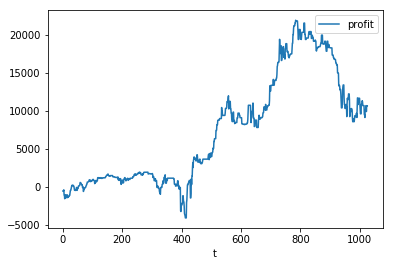

In [67]:
df = pd.read_csv("log.csv")
plt.show(df.plot(x='t',y='profit'))

WOW, this time the algorithm worked a lot better.  Not sure if that's a fluke from the price movements though or if it's because of my adjustment to bias it towards buys rather than sells.

What I really want to do now is try to run in parallel and see how well it performs with varying the parameters.  First, though I should verify that the algorithm worked as intended.

The nice thing is NOW I have some backtesting data to work off of.

I'm also curious how it would fair after taxes.

In [70]:
# environment setup
t = 1
start_val = 10**6
act = {'dol': start_val, 'eth': 0, 'net': 0}
unit = 100
last = 0
fee_pc = 0.0025

log_file = "log2.csv"

# run params
thres = 0.1
spread = 0.0001
tdelta = 100

prices =[]

# initial purchase
res = client.get_spot_price(currency_pair = 'ETH-USD')
data = json.loads(str(res))
curr_price = float(data['amount'])
prices.append(curr_price)
coin_num = unit*5
order_amount = curr_price * coin_num
order_tot = order_amount * (1+fee_pc)
act['dol'] -= order_tot
act['eth'] += coin_num

file = open(log_file,"w+")
file.write("t,spot_price,act_dol,act_eth,net_worth,profit,threshold,target_price,price_gap\n")
file.close()

while True:
    res = client.get_spot_price(currency_pair = 'ETH-USD')
    data = json.loads(str(res))
    
    curr_price = float(data['amount'])
    prices.append(curr_price)
    coin_num = unit
    order_amount = curr_price * coin_num
    order_tot = order_amount * (1+fee_pc)
    
    thres = curr_price * (fee_pc + spread)
    
    if t < tdelta:
        target_price = curr_price
    else:
        target_price = np.average(prices[t-tdelta:t])
    
    # buy
    if target_price - thres > curr_price and act['dol'] > order_tot:
        act['dol'] -= order_tot
        act['eth'] += coin_num
    
    # sell
    if target_price + 5*thres < curr_price and act['eth'] > coin_num:
        act['dol'] += order_amount *(1-fee_pc)
        act['eth'] -= coin_num
        
    # update total net worth
    act['net'] = act['dol'] + act['eth'] * curr_price
    print(f'timestep: {t}, spot price: ${curr_price:,.2f}, account: ${act}')
    print(f'threshold: ${thres:,.2f}')
    print(f'target price: ${target_price:,.2f}')
    print(f'price gap: ${curr_price-target_price:,.2f}')
    print(f"Profit: ${float(act['net'])-start_val:,.2f}, {(float(act['net'])-start_val)/start_val:,.2f}%")
    print('*'*50)
    
    # log data in csv file
    file = open(log_file,'a')
    file.write(f"{t},{curr_price:,.2f},{act['dol']},{act['eth']},{act['net']},{float(act['net'])-start_val},{thres},{target_price},{curr_price-target_price}\n")
    file.close()
    
    last = curr_price
    t += 1
    sleep(30)

timestep: 1, spot price: $417.85, account: ${'dol': 790552.6875, 'eth': 500, 'net': 999477.6875}
threshold: $1.09
target price: $417.85
price gap: $0.00
Profit: $-522.31, -0.00%
**************************************************


KeyboardInterrupt: 